In [65]:
# Cell 1: Setup
import data_loader
import importlib
importlib.reload(data_loader)

# Setup
from data_loader import *
import matplotlib.pyplot as plt
import numpy as np


print("BOX_SIZE2:", BOX_SIZE)
plt.rcParams.update({'font.size': 14})


Loading bubble data...
✓ Loaded 634277 observations
✓ Timesteps added: 0 to 3426
✓ Identified 300 disappearing bubbles
Applying periodic boundary corrections...
✓ Periodic boundary correction applied
✓ Derived quantities computed

DATA LOADING COMPLETE
Total observations:       634,277
Unique bubbles:           400
Timesteps:                0 to 3426
Disappearing bubbles:     300
Box size:                 22.36068
Initial avg area (A_0):   1.000000

Available variables:
  - df: Original dataframe
  - df_corrected: Corrected dataframe with actual_area column
  - disappearing_ids: Set of disappearing bubble IDs
  - bubbles_per_timestep: Number of bubbles at each timestep
  - avg_area_per_timestep: Average bubble area at each timestep
  - approx_avg_area: Approximate area from liquid fraction
  - A_0: Initial average bubble area
  - max_timestep: Maximum timestep
  - final_step: Final timestep
  - box_area: Total box area
  - BOX_SIZE, PERIODIC_THRESHOLD, LIQUID_FRACTION: Constants

BOX_S

/var/folders/l1/x0797x3512d9sktcpm47npbh0000gn/T/ipykernel_15589/2506610126.py:24: RuntimeWarning: invalid value encountered in log
  r_y = np.log(y[dt:] / y[:-dt])
/var/folders/l1/x0797x3512d9sktcpm47npbh0000gn/T/ipykernel_15589/2506610126.py:23: RuntimeWarning: invalid value encountered in log
  r_x = np.log(x[dt:] / x[:-dt])


Δt=1: n=1267754, mean=nan, var=nan
Δt=5: n=1264554, mean=nan, var=nan
Δt=20: n=1252554, mean=nan, var=nan
Δt=100: n=1190584, mean=nan, var=nan
Δt=400: n=994782, mean=nan, var=nan
Δt=700: n=834726, mean=nan, var=nan


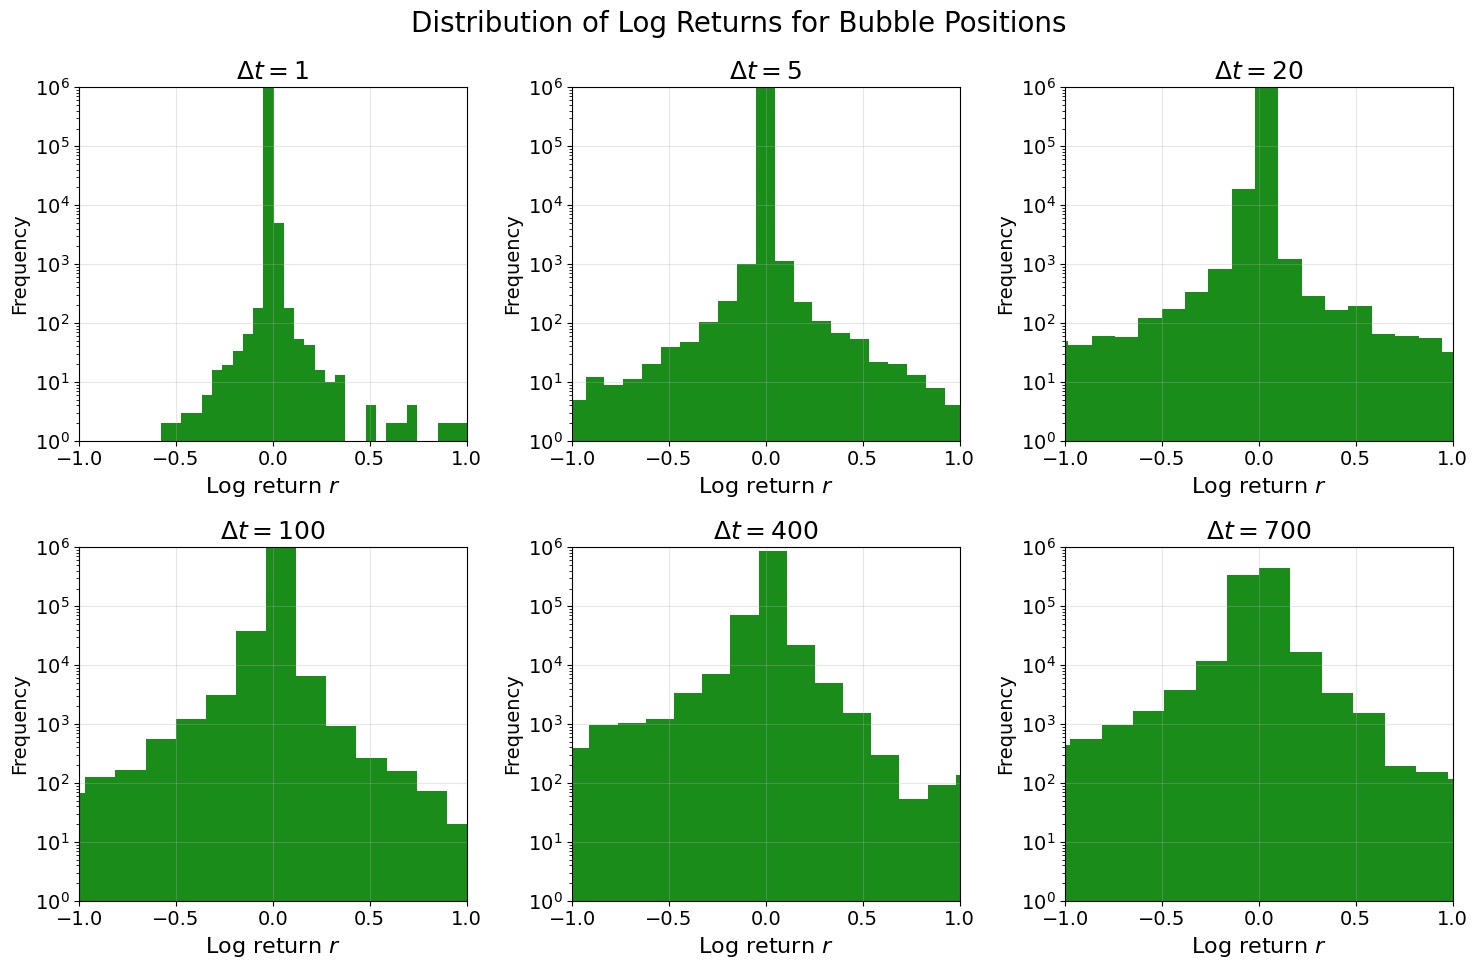

In [66]:

# Log Returns for Multiple dt Values
dt_values = [1, 5, 20, 100, 400, 700]

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.ravel()
plt.suptitle('Distribution of Log Returns for Bubble Positions', 
             fontsize=20, y=0.97)

for idx, dt in enumerate(dt_values):
    log_ret_x, log_ret_y = [], []
    
    for bubble_id, g in df_corrected.groupby("id"):
        g = g.sort_values("timestep").copy()
        x, y = g["x"].to_numpy(), g["y"].to_numpy()
        
        if len(x) <= dt:
            continue
        
        eps = 1e-6
        valid_x = (np.abs(x[:-dt]) > eps)
        valid_y = (np.abs(y[:-dt]) > eps)
        
        r_x = np.log(x[dt:] / x[:-dt])
        r_y = np.log(y[dt:] / y[:-dt])
        
        log_ret_x.extend(r_x[valid_x])
        log_ret_y.extend(r_y[valid_y])
    
    all_r = np.concatenate([log_ret_x, log_ret_y])
    
    axs[idx].hist(all_r, bins=80, alpha=0.9, color='green')
    axs[idx].set_title(rf"$\Delta t = {dt}$", fontsize=18)
    axs[idx].grid(alpha=0.3)
    axs[idx].set_yscale('log')
    axs[idx].set_xlim(-1, 1)
    axs[idx].set_ylim(1, 1e6)
    axs[idx].set_xlabel(r"Log return $r$", fontsize=16)
    axs[idx].set_ylabel("Frequency")
    
    mean_r, var_r = np.mean(all_r), np.var(all_r)
    print(f"Δt={dt}: n={len(all_r)}, mean={mean_r:.5e}, var={var_r:.5e}")

plt.tight_layout(rect=[0, 0, 1, 0.99])
# plt.savefig("Figures/log_returns.png", dpi=300, bbox_inches='tight')
plt.show()

## 📌 Correcting Log-Return Definition for Bubble Trajectories

Bubble positions (`x`, `y`) can be negative, cross zero, or be very small.  
Computing log-returns directly as  
\[
r(t,\Delta t) = \ln\!\left(\frac{x(t+\Delta t)}{x(t)}\right)
\]  
is **mathematically invalid**, because:
- logarithms of negative or zero values are undefined,
- sign changes create artificial “infinite” returns,
- masking small values does not prevent invalid ratios,
- resulting PDFs and CCDFs are dominated by numerical artefacts.

### ✔️ Correct Approach
We construct strictly positive “price-like” coordinates:
\[
S_x = x + \text{offset}, \qquad S_y = y + \text{offset},
\]
then compute valid log-returns:
\[
r_x = \ln\!\left(\frac{S_x(t+\Delta t)}{S_x(t)}\right).
\]

This ensures:
- all logs are defined,
- no masking is needed,
- no sign-flip artefacts,
- centred, symmetric distributions after subtracting the mean,
- results directly comparable to Gaussian walk log-returns.

### ✔️ Why This Matters
With the corrected definition:
- PDFs across Δt are stable and physically meaningful,
- CCDF curves are smooth,
- scaling exponents β are accurate,
- dynamic collapses \(p(r,\Delta t)\) using \(r / \Delta t^{\beta}\) work properly,
- bubble vs Gaussian comparisons are now valid.

This updated definition removes numerical artefacts and preserves the statistical structure needed for scaling and collapse analysis.

In [67]:
# Make globally positive coordinates for x and y
min_x = df_corrected["x"].min()
min_y = df_corrected["y"].min()

offset_x = 1.0 - min_x   # ensures min Sx ≈ 1
offset_y = 1.0 - min_y

df_corrected["Sx"] = df_corrected["x"] + offset_x
df_corrected["Sy"] = df_corrected["y"] + offset_y

In [68]:
def get_signed_logreturns_bubbles(dt):
    """Return pooled signed log-returns r_x, r_y for all bubbles at lag dt."""
    log_ret_x, log_ret_y = [], []

    for bubble_id, g in df_corrected.groupby("id"):
        g = g.sort_values("timestep").copy()
        Sx = g["Sx"].to_numpy()
        Sy = g["Sy"].to_numpy()

        if len(Sx) <= dt:
            continue

        r_x = np.log(Sx[dt:] / Sx[:-dt])
        r_y = np.log(Sy[dt:] / Sy[:-dt])

        log_ret_x.extend(r_x)
        log_ret_y.extend(r_y)

    all_r = np.concatenate([log_ret_x, log_ret_y])
    all_r = all_r - all_r.mean()     # recentre (should be ~0 anyway)
    return all_r

Δt=1: n=1267754, mean=3.19645e-21, var=4.41503e-07
Δt=5: n=1264554, mean=1.07550e-20, var=4.72634e-06
Δt=20: n=1252554, mean=-3.90002e-21, var=3.50315e-05
Δt=100: n=1190584, mean=-4.47601e-20, var=3.30668e-04
Δt=400: n=994782, mean=2.85708e-20, var=1.96793e-03
Δt=700: n=834726, mean=2.14510e-18, var=3.41279e-03


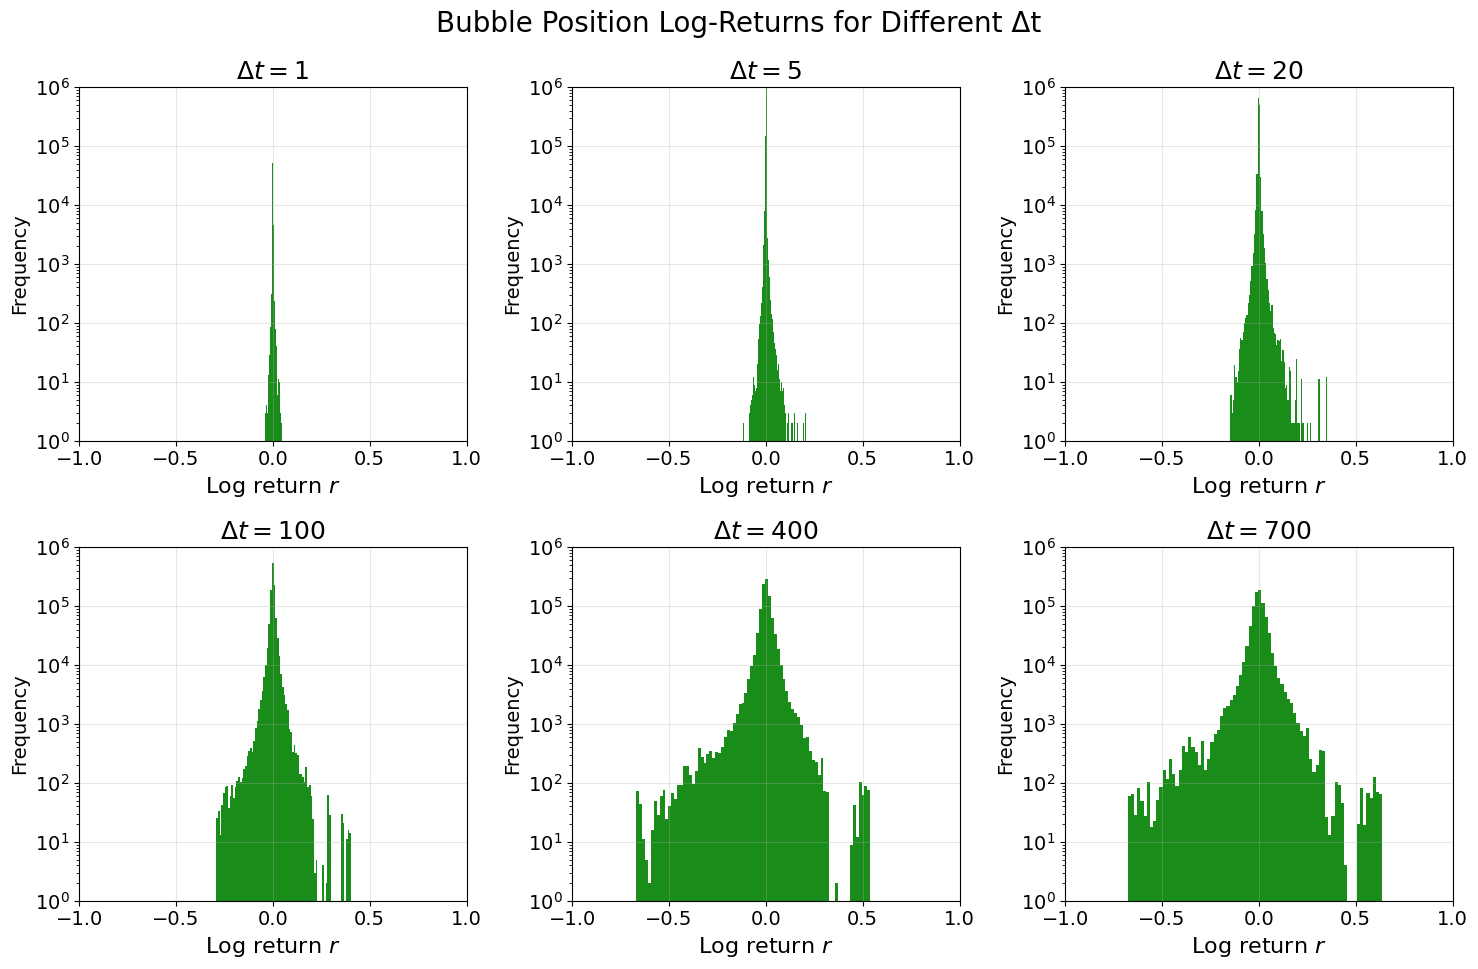

In [69]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.ravel()
plt.suptitle('Bubble Position Log-Returns for Different Δt', fontsize=20, y=0.97)

for idx, dt in enumerate(dt_values):
    all_r = get_signed_logreturns_bubbles(dt)
    if all_r.size == 0:
        continue

    axs[idx].hist(all_r, bins=80, alpha=0.9, color='green')
    axs[idx].set_title(rf"$\Delta t = {dt}$", fontsize=18)
    axs[idx].grid(alpha=0.3)
    axs[idx].set_yscale('log')
    axs[idx].set_xlim(-1, 1)
    axs[idx].set_ylim(1, 1e6)
    axs[idx].set_xlabel(r"Log return $r$", fontsize=16)
    axs[idx].set_ylabel("Frequency")

    mean_r, var_r = np.mean(all_r), np.var(all_r)
    print(f"Δt={dt}: n={len(all_r)}, mean={mean_r:.5e}, var={var_r:.5e}")

plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.savefig("/Users/conorkirby/Library/Mobile Documents/com~apple~CloudDocs/Coding/projects/python/capstone/Figures_Sample2/04_Figures/log_returns_seperate_bubbles_2.png", dpi=300, bbox_inches='tight')
plt.show()

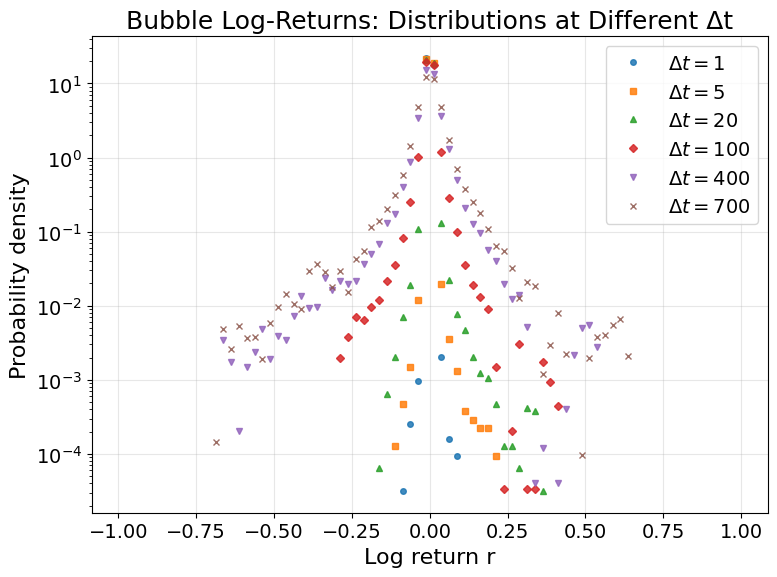

In [70]:
plt.figure(figsize=(8, 6))
markers = ['o', 's', '^', 'D', 'v', 'x']

for idx, dt in enumerate(sorted(dt_values)):
    all_r = get_signed_logreturns_bubbles(dt)
    if all_r.size == 0:
        continue

    counts, edges = np.histogram(all_r, bins=80, range=(-1, 1), density=True)
    centers = 0.5 * (edges[:-1] + edges[1:])

    plt.plot(
        centers, counts,
        marker=markers[idx % len(markers)],
        linestyle='none',
        alpha=0.85,
        markersize=4,
        label=rf'$\Delta t = {dt}$'
    )

plt.yscale('log')
plt.xlabel("Log return r", fontsize=16)
plt.ylabel("Probability density", fontsize=16)
plt.title("Bubble Log-Returns: Distributions at Different Δt", fontsize=18)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
#plt.savefig("/Users/conorkirby/Library/Mobile Documents/com~apple~CloudDocs/Coding/projects/python/capstone/Figures/03_Figures/log_returns_overlay_bubbles.png", dpi=300, bbox_inches='tight')
plt.show()

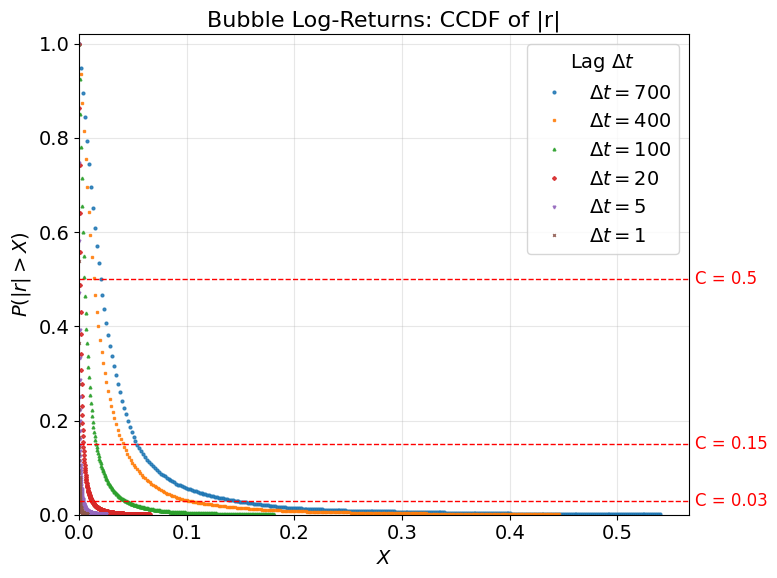

In [71]:
plt.figure(figsize=(8, 6))
markers = ['o', 's', '^', 'D', 'v', 'x']

C_vals = [0.50, 0.15, 0.03]
dt_plot_order = sorted(dt_values, reverse=True)

for idx, dt in enumerate(dt_plot_order):
    all_r = get_signed_logreturns_bubbles(dt)
    if all_r.size == 0:
        continue

    vals = np.abs(all_r)
    vals_sorted = np.sort(vals)
    n = vals_sorted.size

    X = np.linspace(0, np.quantile(vals_sorted, 0.999), 300)
    F = np.searchsorted(vals_sorted, X, side='right') / n
    CCDF = 1.0 - F

    plt.plot(
        X, CCDF,
        marker=markers[idx % len(markers)],
        linestyle='none', ms=2, alpha=0.85,
        label=rf'$\Delta t = {dt}$'
    )

for C in C_vals:
    plt.axhline(y=C, color='red', linestyle='--', linewidth=1)
    xmax = plt.xlim()[1]
    plt.text(1.01 * xmax, C, f"C = {C}",
             va='center', ha='left', fontsize=12, color='red')

plt.ylim(0, 1.02)
plt.xlim(left=0)
plt.ylabel(r"$P(|r|>X)$", fontsize=14)
plt.xlabel(r"$X$", fontsize=14)
plt.title("Bubble Log-Returns: CCDF of |r|", fontsize=16)
plt.grid(alpha=0.3)
plt.legend(title=r"Lag $\Delta t$")
plt.tight_layout()
plt.savefig("/Users/conorkirby/Library/Mobile Documents/com~apple~CloudDocs/Coding/projects/python/capstone/Figures_Sample2/04_Figures/ccdf_logreturns_bubbles_2.png", dpi=300, bbox_inches='tight')
plt.show()

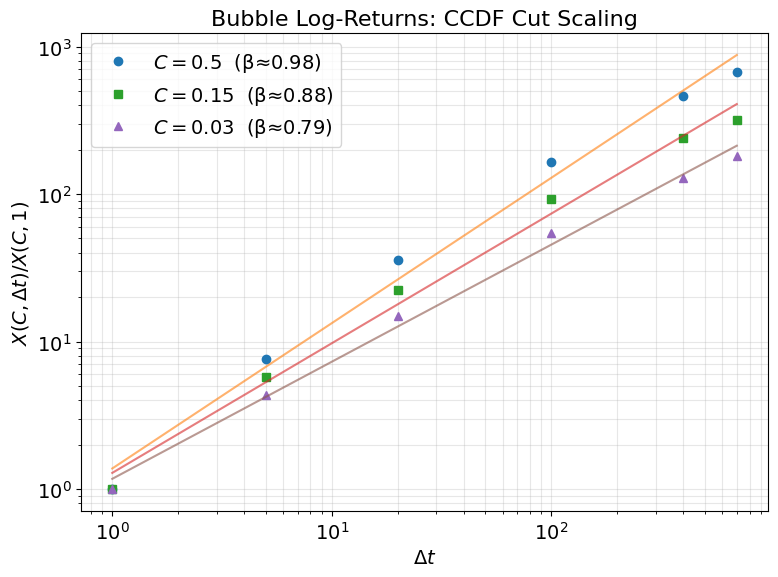

In [72]:
C_vals = [0.50, 0.15, 0.03]

def get_abs_logreturns_bubbles(dt):
    all_r = get_signed_logreturns_bubbles(dt)
    return np.abs(all_r)

dt_plot_order = sorted(dt_values)
assert 1 in dt_plot_order, "Need Δt=1 included for normalization."

abs_lr_samples = {
    dt: get_abs_logreturns_bubbles(dt)
    for dt in dt_plot_order
    if get_abs_logreturns_bubbles(dt).size > 0
}

X_C_dt_lr = {C: {} for C in C_vals}

for C in C_vals:
    q = 1.0 - C
    for dt, vals in abs_lr_samples.items():
        X_C_dt_lr[C][dt] = float(np.quantile(vals, q))

plt.figure(figsize=(8, 6))
markers = ['o', 's', '^', 'D', 'v', 'x']

for i, C in enumerate(C_vals):
    dts = np.array(sorted(X_C_dt_lr[C].keys()))
    Xs  = np.array([X_C_dt_lr[C][dt] for dt in dts])
    X1  = X_C_dt_lr[C][1]

    ratio = Xs / X1

    beta_lr, logA_lr = np.polyfit(np.log(dts), np.log(ratio), 1)
    A_lr = np.exp(logA_lr)
    fit_curve = A_lr * dts**beta_lr

    plt.loglog(
        dts, ratio,
        marker=markers[i % len(markers)],
        linestyle='none',
        label=fr'$C={C}$  (β≈{beta_lr:.2f})'
    )
    plt.loglog(dts, fit_curve, linestyle='-', alpha=0.6)

plt.xlabel(r'$\Delta t$', fontsize=14)
plt.ylabel(r'$X(C,\Delta t)/X(C,1)$', fontsize=14)
plt.title('Bubble Log-Returns: CCDF Cut Scaling', fontsize=16)
plt.grid(alpha=0.3, which='both')
plt.legend()
plt.tight_layout()
plt.savefig("/Users/conorkirby/Library/Mobile Documents/com~apple~CloudDocs/Coding/projects/python/capstone/Figures_Sample2/04_Figures/logreturn_ccdf_cut_scaling_2.png", dpi=300, bbox_inches='tight')
plt.show()

Using beta_collapse_lr = 0.800


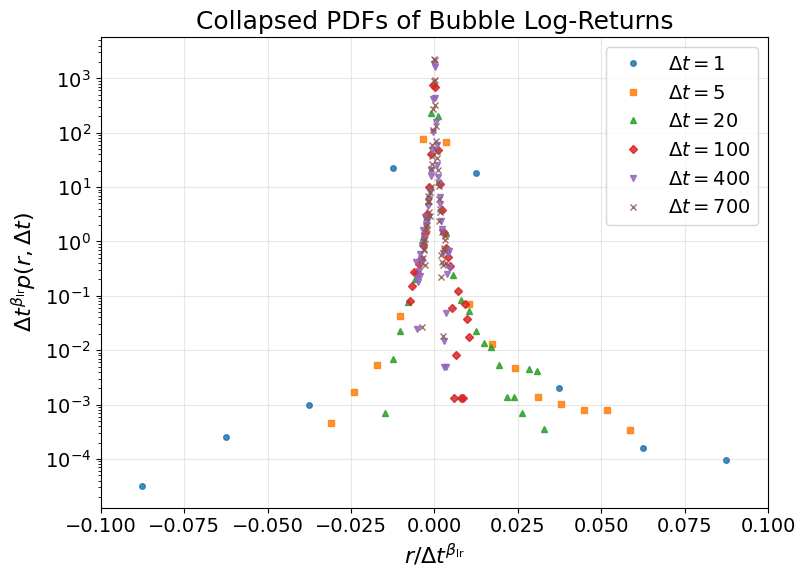

In [73]:
# ==== Collapse signed log-return PDFs for bubbles ====
# choose beta_collapse_lr manually (e.g. from CCDF cuts or some fit you did elsewhere)
beta_collapse_lr = 0.8  

print(f"Using beta_collapse_lr = {beta_collapse_lr:.3f}")

plt.figure(figsize=(8, 6))
markers = ['o', 's', '^', 'D', 'v', 'x']

# keep dt ordering consistent with other plots
dt_plot_order = sorted(dt_values)

for idx, dt in enumerate(dt_plot_order):
    # your helper: returns signed log-returns for a given dt
    all_r = get_signed_logreturns_bubbles(dt)
    if all_r.size == 0:
        continue

    # histogram as PDF over some symmetric range in r
    bins = 80
    rng = (-1, 1)
    counts, edges = np.histogram(all_r, bins=bins, range=rng, density=True)
    centers = 0.5 * (edges[:-1] + edges[1:])

    # scaling factor s(dt) = dt^beta
    s_dt = dt ** beta_collapse_lr

    # rescale x and p(x) according to dynamic scaling ansatz
    x_scaled   = centers / s_dt
    pdf_scaled = counts * s_dt

    plt.plot(
        x_scaled, pdf_scaled,
        marker=markers[idx % len(markers)],
        linestyle='none',
        alpha=0.85,
        markersize=4,
        label=rf'$\Delta t = {dt}$'
    )

plt.yscale('log')  # log y, as you had
plt.xlabel(r"$r / \Delta t^{\beta_{\mathrm{lr}}}$", fontsize=16)
plt.ylabel(r"$\Delta t^{\beta_{\mathrm{lr}}} p(r,\Delta t)$", fontsize=16)
plt.title("Collapsed PDFs of Bubble Log-Returns", fontsize=18)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.xlim(-0.1, 0.1)
plt.savefig("/Users/conorkirby/Library/Mobile Documents/com~apple~CloudDocs/Coding/projects/python/capstone/Figures_Sample2/04_Figures/logreturn_pdf_collapse_beta_lr_2.png", dpi=300, bbox_inches='tight')
plt.show()

In [74]:
import numpy as np
from scipy.stats import levy_stable
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def fit_levy_peak(x_peak, y_peak, beta_collapse, fit_loc=False):
    alpha = 1.0 / beta_collapse

    if fit_loc:
        def model(x, scale, loc):
            return levy_stable.pdf(x, alpha, 0.0, loc=loc, scale=scale)
        p0 = [0.01, 0.0]  # initial guesses
        popt, pcov = curve_fit(model, x_peak, y_peak, p0=p0)
        scale_fit, loc_fit = popt
    else:
        def model(x, scale):
            return levy_stable.pdf(x, alpha, 0.0, loc=0.0, scale=scale)
        p0 = [0.01] # initial guess for scale
        popt, pcov = curve_fit(model, x_peak, y_peak, p0=p0)
        scale_fit = popt[0]
        loc_fit = 0.0

    return alpha, scale_fit, loc_fit

def build_collapsed_logreturn_pdfs(dt_values,
                                   beta_collapse_lr,
                                   x_cut,
                                   bins,
                                   rng=(-1, 1),
                                   exclude_dt=None):
    if exclude_dt is None:
        exclude_dt = []

    collapse_dict = {}
    x_peak_list, y_peak_list = [], []

    for dt in sorted(dt_values):
        if dt in exclude_dt:
            continue

        all_r = get_signed_logreturns_bubbles(dt)
        if all_r.size == 0:
            continue

        s_dt = dt ** beta_collapse_lr
        x = all_r / s_dt  # scaled samples

        counts, edges = np.histogram(x, bins=bins, range=(-0.01, 0.01), density=True)
        centers = 0.5 * (edges[:-1] + edges[1:])

        x_scaled = centers
        pdf_scaled = counts  # already the collapsed PDF in x

        collapse_dict[dt] = (x_scaled, pdf_scaled)

        # collect peak region for Lévy fit
        mask = np.abs(x_scaled) <= x_cut
        x_peak_list.append(x_scaled[mask])
        y_peak_list.append(pdf_scaled[mask])

    if x_peak_list:
        x_peak = np.concatenate(x_peak_list)
        y_peak = np.concatenate(y_peak_list)
    else:
        x_peak = np.array([])
        y_peak = np.array([])

    return collapse_dict, x_peak, y_peak

In [77]:
def levy_collapse_logreturns(dt_values,
                             beta_collapse_lr=0.8,
                             x_cut=0.05,
                             bins=80,
                             rng=(-1, 1),
                             fit_loc=False,
                             make_plot=True,
                             exclude_dt=None):

    # 1. Build collapse + peak data for log-returns
    collapse_dict, x_peak, y_peak = build_collapsed_logreturn_pdfs(
        dt_values,
        beta_collapse_lr,
        x_cut=x_cut,
        bins=bins,
        rng=rng,
        exclude_dt=exclude_dt
    )

    # 2. Fit Lévy peak
    alpha, scale, loc = fit_levy_peak(
        x_peak, y_peak,
        beta_collapse=beta_collapse_lr,
        fit_loc=fit_loc
    )

    # 3. Plot
    if make_plot:
        plt.figure(figsize=(8, 6))
        markers = ['o', 's', '^', 'D', 'v', 'x']

        for idx, dt in enumerate(sorted(collapse_dict.keys())):
            x_scaled, pdf_scaled = collapse_dict[dt]
            plt.plot(
                x_scaled, pdf_scaled,
                marker=markers[idx % len(markers)],
                linestyle='none',
                alpha=0.7,
                markersize=4,
                label=rf'$\Delta t = {dt}$'
            )

        # Lévy fit over peak region
        # Lévy fit (rescaled to match peak height)
        if x_peak.size > 0:

            # use same x-range as the plot for visual consistency
            x_fit = np.linspace(-0.01, 0.01, 2000)

            # raw Lévy pdf
            y_fit = levy_stable.pdf(x_fit, alpha, 0.0, loc=0.0, scale=scale)

            # rescale to match empirical peak height
            y_peak_emp = np.max(y_peak)

            mask_peak = np.abs(x_fit) <= x_cut
            y_peak_fit = np.max(y_fit[mask_peak])

            A = y_peak_emp / y_peak_fit
            y_fit *= A

            plt.plot(
                x_fit, y_fit, 'k-', lw=2,
                label=fr'Lévy fit, $\alpha={alpha:.2f}$'
            )

        plt.yscale('log')
        plt.xlabel(r"$r / \Delta t^{\beta_{\mathrm{lr}}}$", fontsize=16)
        plt.ylabel(r"$\Delta t^{\beta_{\mathrm{lr}}} p(r,\Delta t)$", fontsize=16)
        plt.title("Collapsed PDFs of Bubble Log-Returns with Lévy Peak Fit", fontsize=18)
        plt.grid(alpha=0.3)
        plt.xlim(-0.01, 0.01)
        #plt.ylim(10**0, 10**4)
        plt.legend()
        plt.tight_layout()
        plt.savefig("/Users/conorkirby/Library/Mobile Documents/com~apple~CloudDocs/Coding/projects/python/capstone/Figures_Sample2/04_Figures/logreturn_pdf_collapse_levy_fit_beta_lr_2.png", dpi=300, bbox_inches='tight')

        plt.show()

    return alpha, scale, loc, collapse_dict

The Lévy distribution is rescaled to match the peak height of the collapsed PDF; the fit is intended as a shape comparison in the central region.

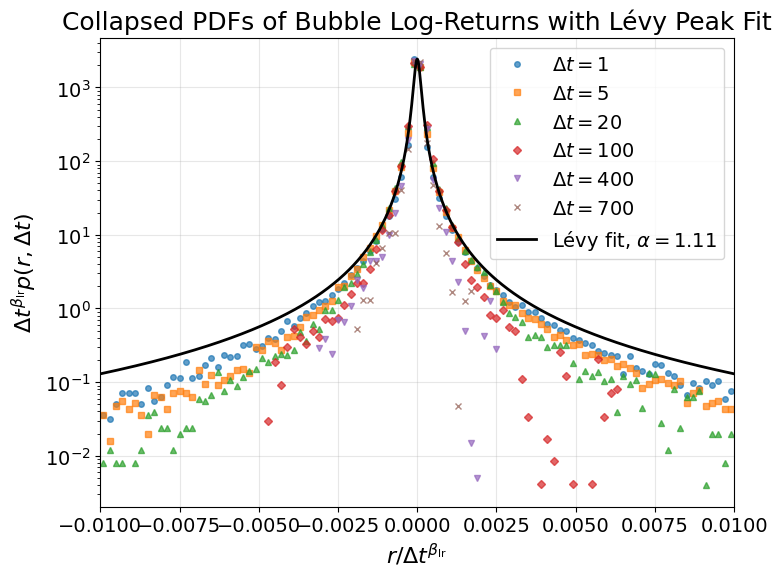

Log-return Lévy parameters:
  alpha = 1.111  (compare to 1/beta ≈ 1.111)
  scale = 9.128e-05
  loc   = 0


In [78]:
beta_lr = .9  # from your CCDF / MSD for log-returns

alpha_lr, scale_lr, loc_lr, collapse_lr = levy_collapse_logreturns(
    dt_values,
    beta_collapse_lr=beta_lr,
    x_cut=0.2,        # maybe tighter for log-returns
    bins=100,
    fit_loc=False,
    make_plot=True,
    exclude_dt=[]     # optional: drop Δt=1 if you don't trust its scaling
)

print("Log-return Lévy parameters:")
print(f"  alpha = {alpha_lr:.3f}  (compare to 1/beta ≈ {1/beta_lr:.3f})")
print(f"  scale = {scale_lr:.4g}")
print(f"  loc   = {loc_lr:.4g}")

#plot from 10^0